In [1]:
import os
from classesCHANGE import PointCloudFiltering, UnsupervisedSegmentationAlgorithm, PointCloudGenerator, CropAnalyzer
import time
import plyfile 
import open3d as o3d
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from scipy.spatial import ConvexHull

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Instantiate classes
pcd_filtering = PointCloudFiltering()
unsup_segmentation = UnsupervisedSegmentationAlgorithm()
pcd_functions = PointCloudGenerator(r"C:/Users/Jay")


In [3]:
# PLYFILE 

In [3]:
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Documents\Github\HarvestEye\main\avoFixed.ply') #Avocado100_30deg_group1_densified_point_cloud.ply')
pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Desktop\avoFixed.ply') # Avocado100_30deg_group1_densified_point_cloud.ply')# 'C:\Users\Jay\Desktop\avoFixed.ply') 
# pcd = o3d.io.read_point_cloud(r'C:\Users\Jay\Downloads\Avocado_s 100 30deg colorized_fixed.ply')
# o3d.visualization.draw_geometries([pcd])


In [5]:
# Estimate normals
pcd.estimate_normals()

# Surface reconstruction using Poisson reconstruction
poisson_mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Sample points from the mesh
densified_pcd = poisson_mesh.sample_points_poisson_disk(number_of_points=np.asarray(pcd.points).shape[0] * 2)

o3d.visualization.draw_geometries([densified_pcd])


In [ ]:
from scipy.spatial import KDTree

def interpolate_points(pcd, factor):
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    tree = KDTree(points)
    new_points = []
    new_colors = []

    for point, color in zip(points, colors):
        # Find nearest neighbors
        distances, indices = tree.query(point, k=factor + 1)
        neighbors = points[indices[1:]]
        neighbor_colors = colors[indices[1:]]
        for neighbor, neighbor_color in zip(neighbors, neighbor_colors):
            # Interpolate points between the point and each neighbor
            interp_point = (point + neighbor) / 2
            interp_color = (color + neighbor_color) / 2
            new_points.append(interp_point)
            new_colors.append(interp_color)

    new_points = np.array(new_points)
    new_colors = np.array(new_colors)
    return new_points, new_colors

def voxel_upsample(pcd, voxel_size, upsampling_factor):
    # Voxelize the point cloud
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)
    voxel_centers = np.asarray([v.grid_index for v in voxel_grid.get_voxels()])
    points = np.asarray(pcd.points)
    colors = np.asarray(pcd.colors)
    tree = KDTree(points)

    # Create new points within each voxel
    new_points = []
    new_colors = []
    for center in voxel_centers:
        for _ in range(upsampling_factor):
            offset = (np.random.rand(3) - 0.5) * voxel_size  # random offset within voxel
            new_point = center * voxel_size + offset

            # Find the nearest point in the original point cloud to interpolate color
            _, nearest_index = tree.query(new_point)
            nearest_color = colors[nearest_index]

            new_points.append(new_point)
            new_colors.append(nearest_color)

    new_points = np.array(new_points)
    new_colors = np.array(new_colors)
    return new_points, new_colors


In [ ]:
factor = 20
#voxel_size = 0.05
#upsampling_factor = 3

new_points_interp, new_colors_interp = interpolate_points(pcd, factor)
#new_points_voxel, new_colors_voxel = voxel_upsample(pcd, voxel_size, upsampling_factor)

# Create new point clouds with interpolated points and colors
interp_pcd = o3d.geometry.PointCloud()
interp_pcd.points = o3d.utility.Vector3dVector(new_points_interp)
interp_pcd.colors = o3d.utility.Vector3dVector(new_colors_interp)

#voxel_pcd = o3d.geometry.PointCloud()
#voxel_pcd.points = o3d.utility.Vector3dVector(new_points_voxel)
#voxel_pcd.colors = o3d.utility.Vector3dVector(new_colors_voxel)



In [ ]:
o3d.visualization.draw_geometries([interp_pcd])
o3d.visualization.draw_geometries([pcd])


In [4]:
# Downsample the point cloud
voxel_size = 0.25
downsampled_pcd = pcd_functions.downsamples_pointcloud(pcd, voxel_size)

# Normalize the point cloud
xyzrgb_normalized = pcd_functions.pcd_array_normalized(downsampled_pcd)

# Define weights and number of clusters for KMeans
weights = [5, 5, 500, 1, 550, 1]
num_clusters = 2
kmeans_labels, kmeans = unsup_segmentation.normalized_and_weighted_kmeans(weights, xyzrgb_normalized, num_clusters)

# Prepare cluster colors array
cluster_colors = np.zeros_like(xyzrgb_normalized[:, :3])  # Use only the XYZ part for colors

# Define colors for clusters
colors = {
    "green": [0, 150/255, 0],  # Green color
    "brown": [0.647, 0.165, 0.165]  # Brown color
}

# Identify the larger cluster
larger_cluster_label = np.argmax(np.bincount(kmeans_labels))

# Assign colors based on cluster sizes
for i in range(num_clusters):
    color = colors["brown"] if i == larger_cluster_label else colors["green"]
    cluster_colors[kmeans_labels == i] = color

seg_pcd = downsampled_pcd
seg_pcd.colors = o3d.utility.Vector3dVector(cluster_colors)
o3d.visualization.draw_geometries([seg_pcd])

In [5]:
# Now use the classes as needed
pcd_filtering = PointCloudFiltering()

ground_points = np.asarray(seg_pcd.points)[kmeans_labels == larger_cluster_label]
crop_points = np.asarray(seg_pcd.points)[kmeans_labels != larger_cluster_label]



In [6]:
x_min, x_max = np.min(ground_points[:, 0]), np.max(ground_points[:, 0])
x_range = x_max - x_min
grid_resolution = x_range / 2

# Filter the Ground Points list
#filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 3, grid_resolution, 0.15)
filtered_ground_points = pcd_filtering.filter_ground_points(ground_points, 1, 7, 0.001)
filtered_ground_pcd = o3d.geometry.PointCloud()
filtered_ground_pcd.points = o3d.utility.Vector3dVector(filtered_ground_points)
# o3d.visualization.draw_geometries([filtered_ground_pcd]) #+ [seg_pcd])

In [7]:
filtered_crop_points = pcd_filtering.filter_points_by_grid(crop_points, 0.75, 0.5, 5)
filtered_crop_pcd = o3d.geometry.PointCloud()
filtered_crop_pcd.points = o3d.utility.Vector3dVector(filtered_crop_points)
# o3d.visualization.draw_geometries([filtered_crop_pcd])

In [8]:
# Filter points based on DBSCAN clustering
eps = 0.28  # epsilon value for DBSCAN
dbscan_labels, clustered_points_xyz = unsup_segmentation.crop_clustering_dbscan(eps, filtered_crop_points)


import random
#Convert clustered_tree_points to an Open3D point cloud
dbscan_clusters_pcd = o3d.geometry.PointCloud()
dbscan_clusters_pcd.points = o3d.utility.Vector3dVector(clustered_points_xyz)

dbscan_clusters_filtered_points, filtered_labels = pcd_filtering.dbscan_cluster_filtering(dbscan_clusters_pcd, 20, 10000, dbscan_labels)
# Ensure dbscan_clusters_filtered_points is a PointCloud object
if isinstance(dbscan_clusters_filtered_points, o3d.geometry.PointCloud):
    # Assign random colors to each cluster
    cluster_colors = {}
    for label in np.unique(filtered_labels):
        if label == -1:  # Skip noise points
            continue
        color = [random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)]  # Generate a random RGB color
        cluster_colors[label] = color

    # Assign colors to each point based on its cluster
    point_colors = []
    for label in filtered_labels:
        if label == -1:  # Noise points
            point_colors.append([0.5, 0.5, 0.5])  # Gray color
        else:
            point_colors.append(cluster_colors[label])

    # Set colors for the clustered tree points
    dbscan_clusters_filtered_points.colors = o3d.utility.Vector3dVector(point_colors)

    # Set the visualization mode to "unlit" for precise color rendering
    o3d.visualization.draw_geometries([dbscan_clusters_filtered_points])
else:
    print(f"Expected dbscan_clusters_filtered_points to be a PointCloud, but got {type(dbscan_clusters_filtered_points)} instead.")

[ 0  1  2 ... 15 12 12]


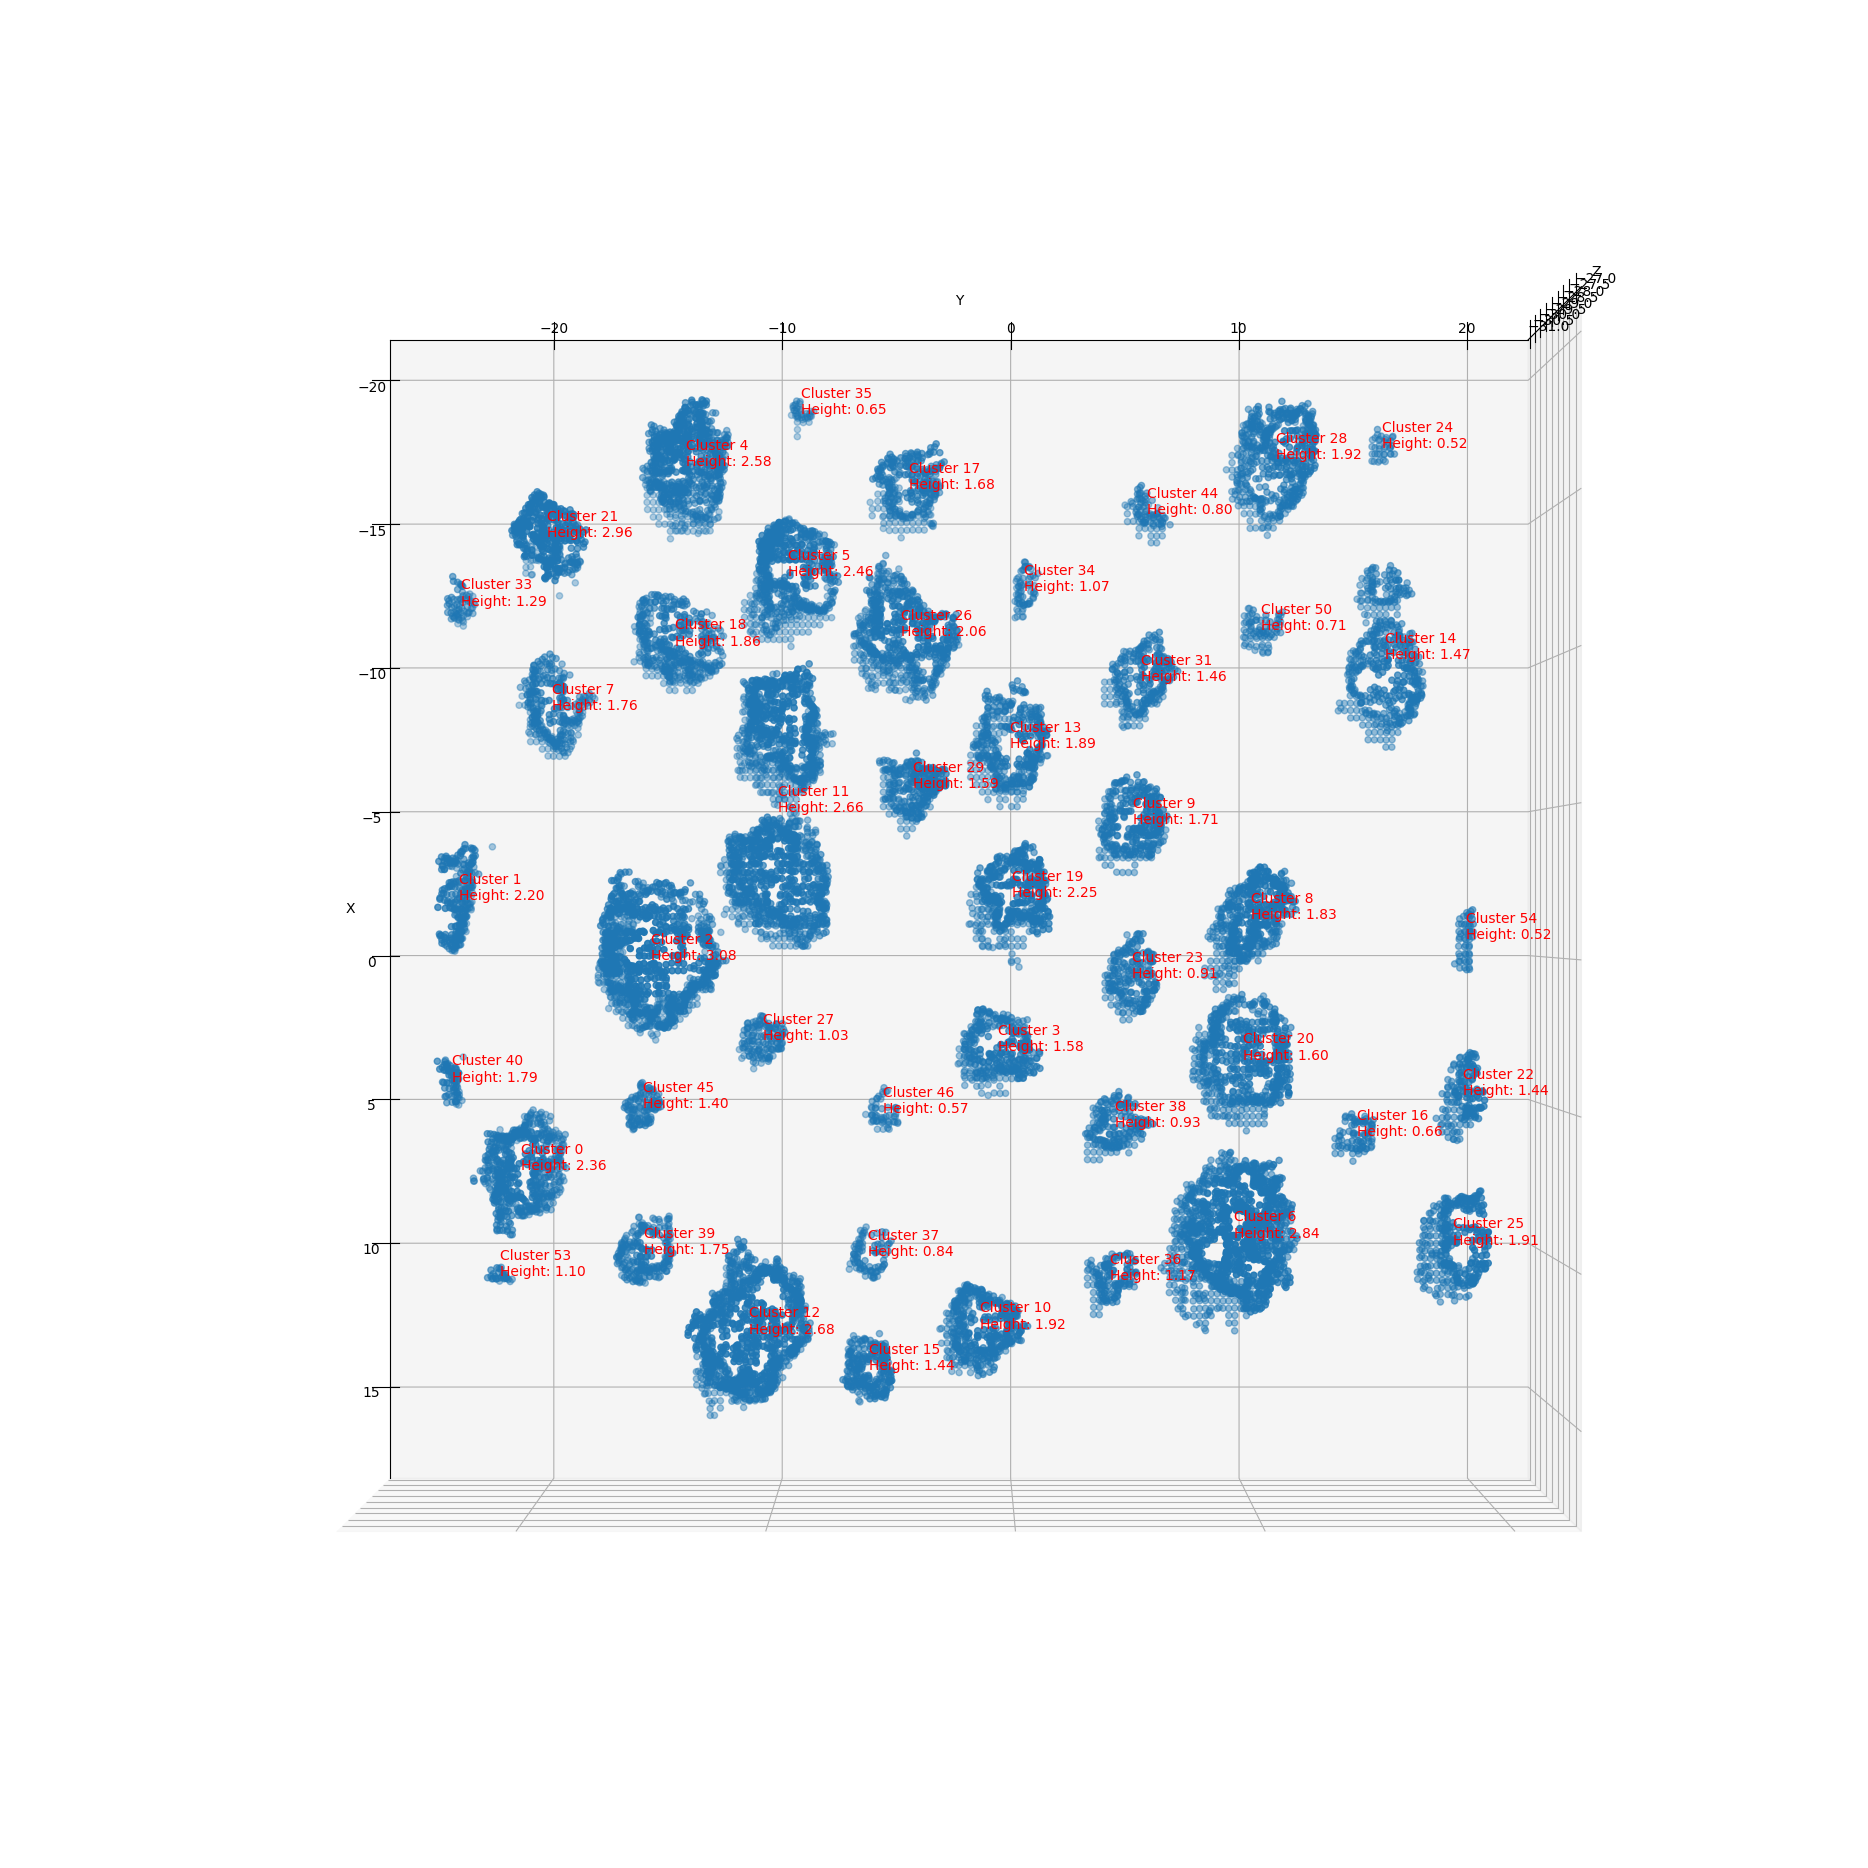

In [10]:
analyzer = CropAnalyzer()

heights, labels = analyzer.calculate_heights_and_labels(filtered_labels, dbscan_clusters_filtered_points, filtered_ground_pcd)

# Calculate cluster centers
cluster_centers = analyzer.calculate_cluster_centers(filtered_labels, np.asarray(dbscan_clusters_filtered_points.points))

# Visualize the heights and point cloud data
analyzer.visualize_the_heights_and_pcd(heights, dbscan_clusters_filtered_points, cluster_centers)

In [11]:
analyzer.visualize_height_gradient(dbscan_clusters_filtered_points, filtered_ground_pcd)


In [24]:
def calculate_oval_volume(cluster_points, ground_points):
    # Step 1: Find furthest XY points in the cluster
    furthest_points = find_furthest_xy_points(cluster_points)

    # Step 2: Calculate maximum height of the cluster
    highest_point = analyzer.calculate_highest_point(cluster_points)
    closest_ground_point = analyzer.find_closest_ground_point(highest_point, ground_points)
    max_height = analyzer.calculate_height_difference(highest_point, closest_ground_point)

    # Step 3: Calculate semi-major and semi-minor axes lengths (a and b)
    print(furthest_points)
    a = np.linalg.norm(furthest_points[0] - furthest_points[1]) / 2.0
    b = np.linalg.norm(furthest_points[0] - furthest_points[2]) / 2.0

    # Step 4: Calculate volume of an ellipsoid (since oval is an extension in Z-direction)
    volume = (4/3) * np.pi * a * b * max_height
    
    return volume

def find_furthest_xy_points(cluster_points):

    # Compute convex hull of the cluster points
    hull = ConvexHull(cluster_points[:, :2])

    # Initialize variables for furthest points and distances
    furthest_points_major = [None, None]
    furthest_points_minor = [None, None]
    max_major_distance = 0
    max_minor_distance = 0

    # Iterate through convex hull vertices to find the maximum distance pair (semi-major axis)
    for i in range(len(hull.vertices)):
        for j in range(i + 1, len(hull.vertices)):
            distance = np.linalg.norm(cluster_points[hull.vertices[i], :2] - cluster_points[hull.vertices[j], :2])
            if distance > max_major_distance:
                max_major_distance = distance
                furthest_points_major = (cluster_points[hull.vertices[i]], cluster_points[hull.vertices[j]])

    # Compute the direction vector for the semi-major axis
    major_axis_vector = furthest_points_major[1][:2] - furthest_points_major[0][:2]
    major_axis_vector /= np.linalg.norm(major_axis_vector)

    # Iterate through convex hull vertices to find the maximum distance perpendicular to the major axis (semi-minor axis)
    for i in range(len(hull.vertices)):
        point = cluster_points[hull.vertices[i], :2]
        # Project the point onto the major axis to get the perpendicular distance
        projection = np.dot(point - furthest_points_major[0][:2], major_axis_vector) * major_axis_vector
        perpendicular_distance = np.linalg.norm(point - furthest_points_major[0][:2] - projection)
    if perpendicular_distance > max_minor_distance:
            max_minor_distance = perpendicular_distance
            furthest_points_minor = (furthest_points_major[0], cluster_points[hull.vertices[i]])

    return (*furthest_points_major, furthest_points_minor[1], furthest_points_minor[0])


def calculate_volumes_for_clusters(dbscan_filtered_pcd, dbscan_filtered_labels, filtered_ground_pcd):
    volumes_dict = {}
    filtered_ground_points = np.asarray(filtered_ground_pcd.points)
    
    for label in np.unique(dbscan_filtered_labels):
        if label == -1:  # Skip noise points
            continue
        
        # Get points belonging to the current cluster
        cluster_indices = np.where(dbscan_filtered_labels == label)[0]
        cluster_points = np.asarray(dbscan_filtered_pcd.points)[cluster_indices]

        # Calculate volume for the current cluster
        volume = calculate_oval_volume(cluster_points, filtered_ground_points)
        
        # Store volume in dictionary with label as key
        volumes_dict[label] = volume
    
    return volumes_dict

(array([  7.61288664, -22.97699643, -29.85585143]), array([  5.9971005, -19.002655 , -29.585135 ]), array([  9.27348257, -21.07927   , -29.09221571]), array([  7.61288664, -22.97699643, -29.85585143]))
(array([ -3.747124, -22.3698  , -30.29333 ]), array([ -0.1738381 , -23.95359208, -30.21010755]), array([ -3.35491432, -23.9650016 , -28.8769664 ]), array([ -3.747124, -22.3698  , -30.29333 ]))
(array([ -2.82915745, -16.46971759, -28.8737612 ]), array([  2.86412985, -15.32611308, -30.26722923]), array([  0.11688377, -12.11534   , -29.306455  ]), array([ -2.82915745, -16.46971759, -28.8737612 ]))
(array([  2.12269056,   0.64483409, -29.60782111]), array([  4.38903001,  -2.01391968, -30.04275588]), array([  1.75087764,  -1.46251614, -29.05427143]), array([  2.12269056,   0.64483409, -29.60782111]))
(array([-18.49415, -12.82702, -28.75146]), array([-14.3545419 , -14.75994217, -30.5680925 ]), array([-16.694568, -15.867944, -30.482435]), array([-18.49415, -12.82702, -28.75146]))
(array([-14.02

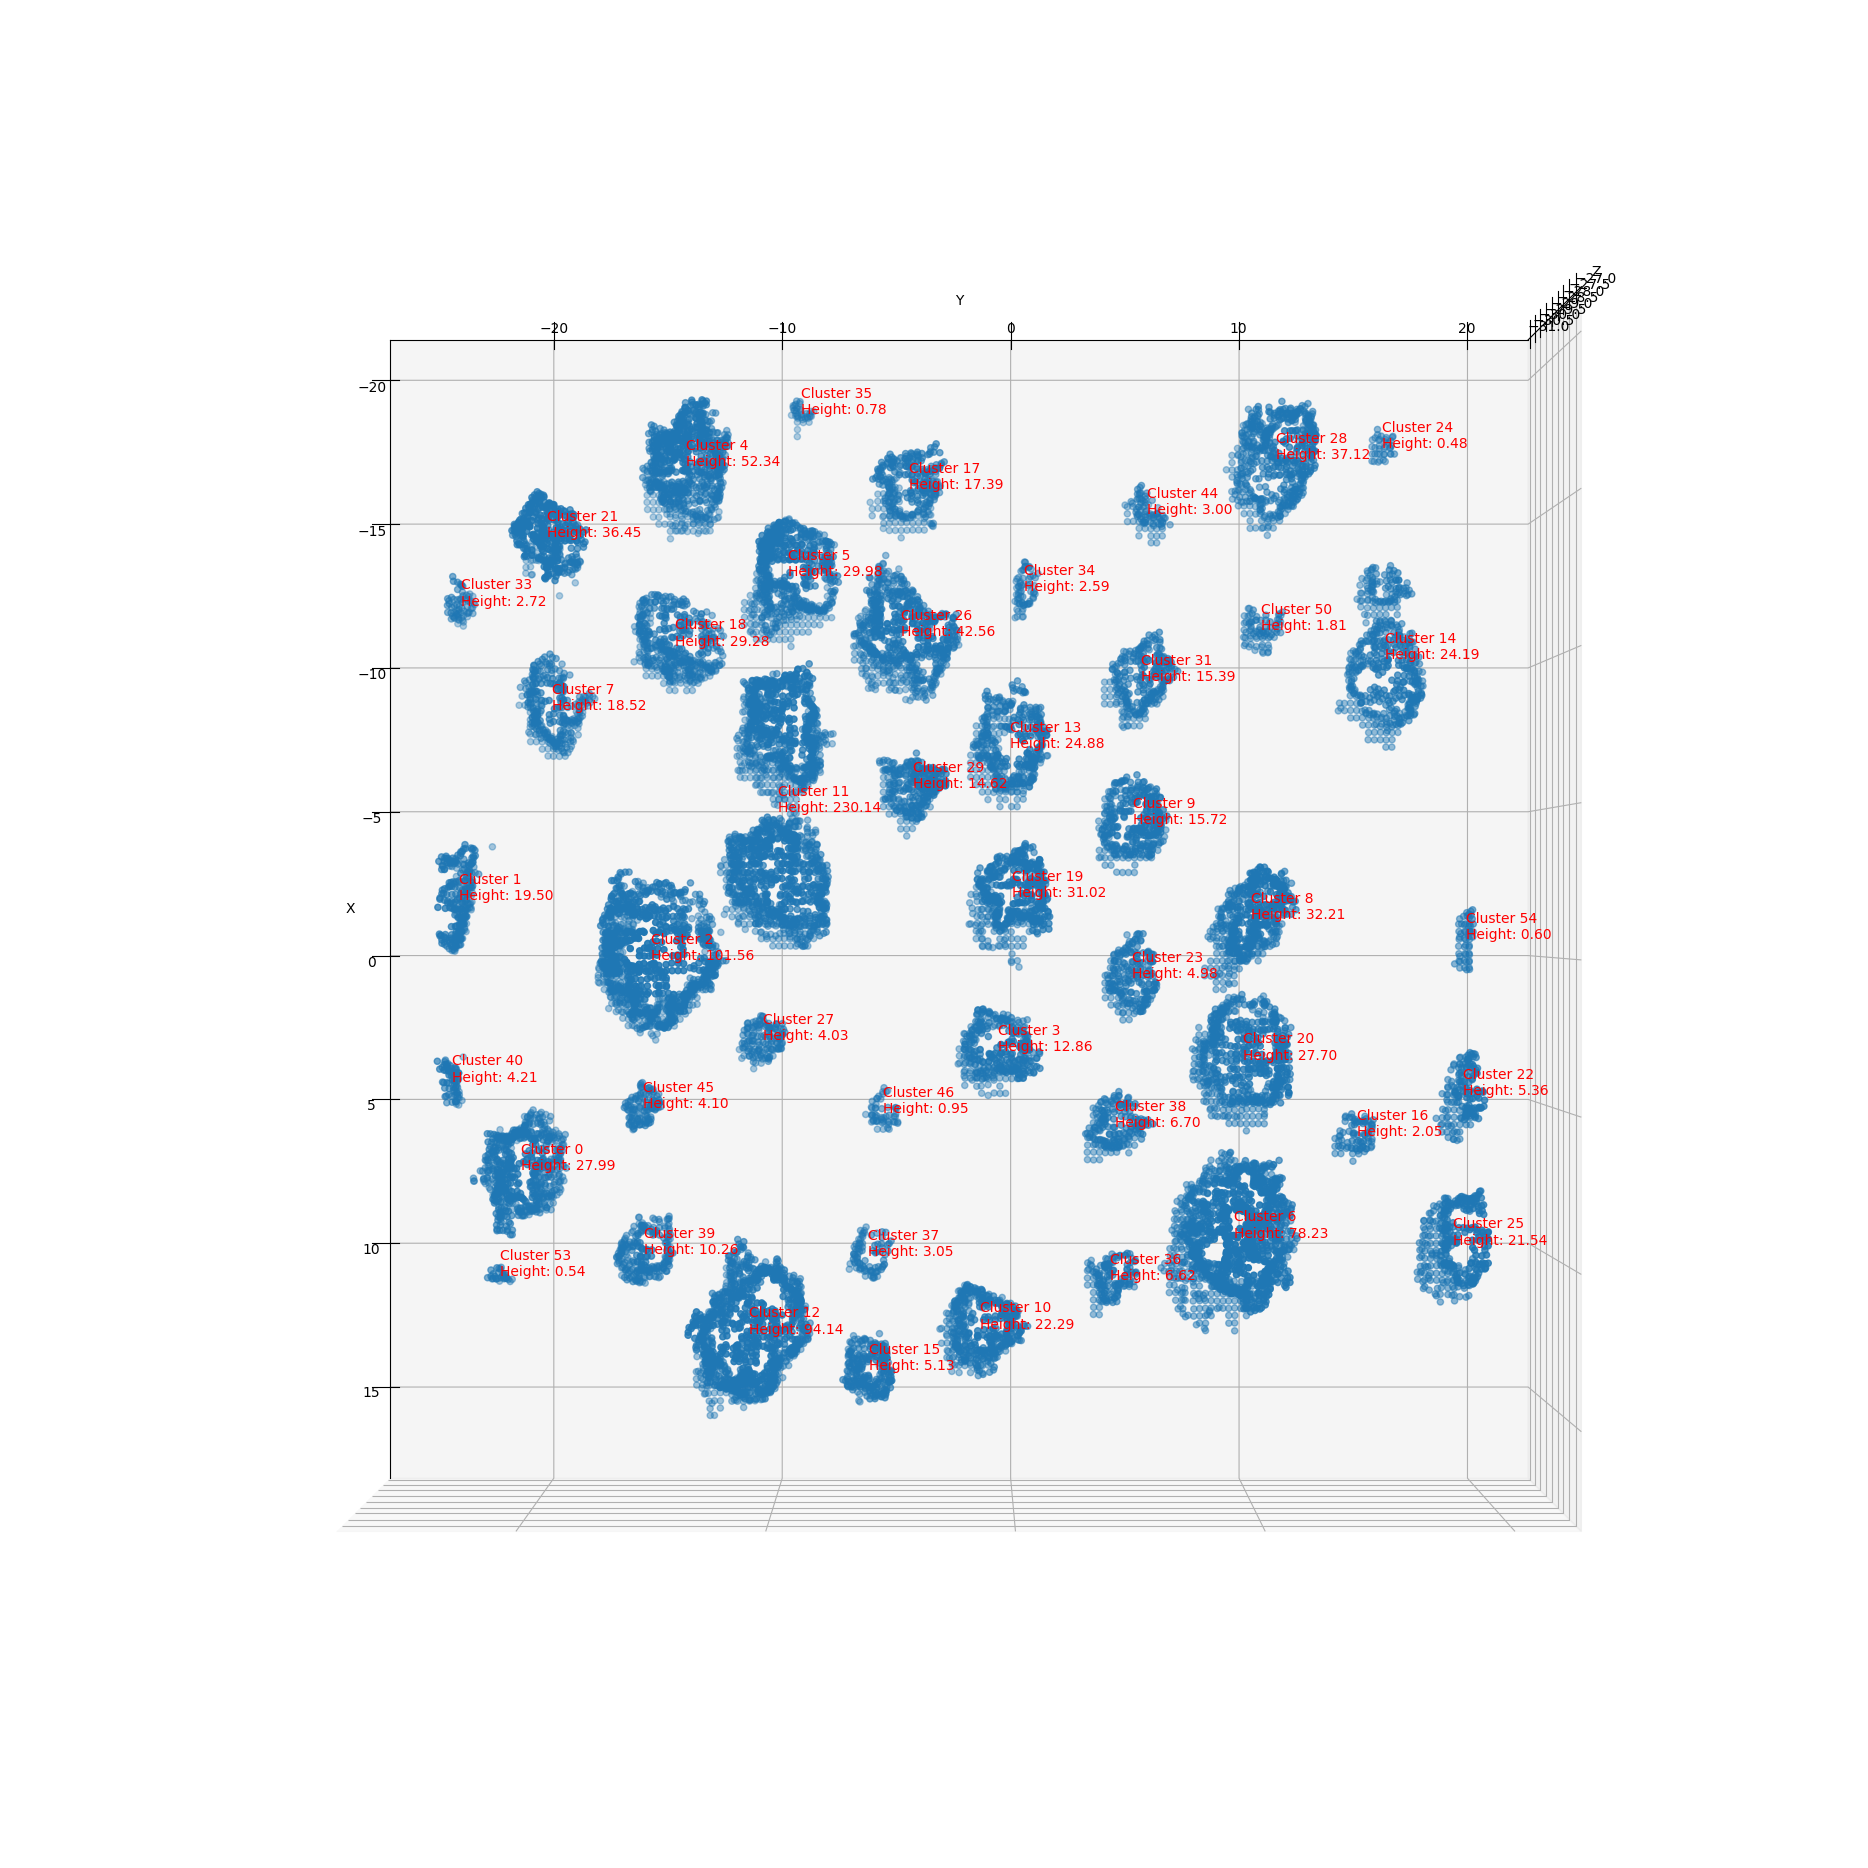

In [26]:
volume_dicts = analyzer.calculate_volumes_for_clusters(dbscan_clusters_filtered_points, filtered_labels, filtered_ground_pcd)
analyzer.visualize_the_heights_and_pcd(volume_dicts, dbscan_clusters_filtered_points, cluster_centers)